<a href="https://www.kaggle.com/code/dataranch/annual-salaries-eda-feature-importance?scriptVersionId=107293537" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Annual Salaries Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

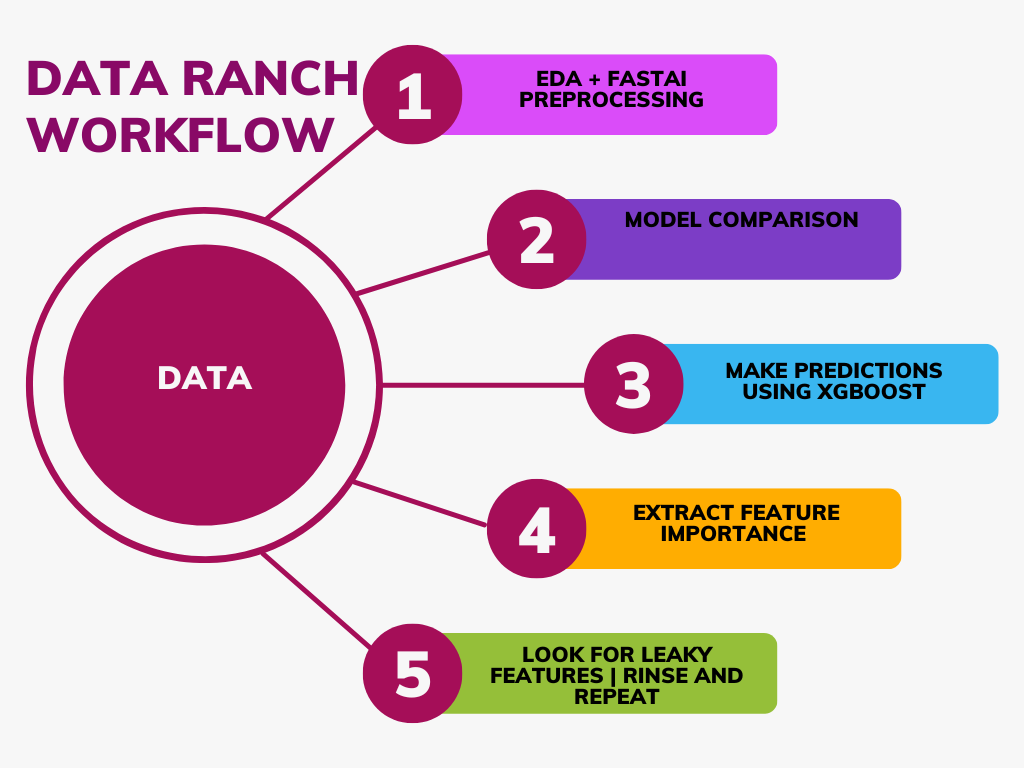

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 515.7 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'anual-salary-reports-survey'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT, sep=';')
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/anual-salary-reports-survey
CSV!


In [12]:
df

,ID,income,age,gender,education_level
0,12182,86519.61,45,M,2.00
1,81213,83085.86,30,M,2.00
2,1996,82606.21,22,M,2.00
3,9366,81551.23,36,M,2.00
4,9733,79593.25,51,M,1.00
...,...,...,...,...,...
1995,25122,60485.18,50,F,3.00
1996,21357,60485.10,29,F,1.00
1997,84681,60484.54,26,M,3.00
1998,957,60481.96,53,M,1.00


In [13]:
df.isna().sum()

ID                 0
income             0
age                0
gender             0
education_level    1
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,ID,income,age,gender,education_level
0,12182,86519.61,45,M,2.00
1,81213,83085.86,30,M,2.00
2,1996,82606.21,22,M,2.00
3,9366,81551.23,36,M,2.00
4,9733,79593.25,51,M,1.00


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
ID,2000.00,49888.26,29669.64,0.00,24024.75,49813.00,76021.75,99997.00
income,2000.00,64420.15,4132.77,60474.51,61607.04,63286.53,65878.73,112068.50
age,2000.00,41.93,11.82,18.00,32.00,41.00,51.00,64.00
education_level,1999.00,1.98,0.89,0.00,1.00,2.00,3.00,3.00


In [17]:
df.columns

Index(['ID', 'income', 'age', 'gender', 'education_level'], dtype='object')

In [18]:
#remove 'Unnamed:0' as it's a leaky feature
del(df['ID'])

Target Variable: education_level
CATS=====================
['age', 'gender', 'education_level']
CONTS=====================
['income']
4
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['income']
Categorical variables that made the cut : ['age', 'gender', 'education_level']
Tabular Object size: 2000


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.010059343166484158, 'Adjusted R-Squared': -0.017711307887442462, 'RMSE': 0.8917757066500727, 'Time taken': 0.03228640556335449}
{'Model': 'BaggingRegressor', 'R-Squared': -0.24053185155784873, 'Adjusted R-Squared': -0.24992982013025666, 'RMSE': 0.9882939846017479, 'Time taken': 0.05536937713623047}


 17%|█▋        | 7/42 [00:00<00:01, 32.71it/s]

{'Model': 'BayesianRidge', 'R-Squared': -0.001644108201764194, 'Adjusted R-Squared': -0.009232321142686573, 'RMSE': 0.8880530548998651, 'Time taken': 0.03403973579406738}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.1496328636634252, 'Adjusted R-Squared': -1.165917961115421, 'RMSE': 1.3009611831257688, 'Time taken': 0.025058984756469727}
{'Model': 'DummyRegressor', 'R-Squared': -0.0016119269696368566, 'Adjusted R-Squared': -0.009199896113346151, 'RMSE': 0.8880387889191553, 'Time taken': 0.01495218276977539}
{'Model': 'ElasticNet', 'R-Squared': -0.001611929087810715, 'Adjusted R-Squared': -0.009199898247566951, 'RMSE': 0.88803875, 'Time taken': 0.0183866024017334}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,2) we computed 16.203903198242188 but the user-supplied value was 16.203916549682617.
{'Model': 'ExtraTreeRegressor',

 26%|██▌       | 11/42 [00:00<00:03,  9.17it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -120344.91935086058, 'Adjusted R-Squared': -121256.63086109437, 'RMSE': 307.8207391305923, 'Time taken': 0.456850528717041}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.054357663565942405, 'Adjusted R-Squared': -0.06234522162326006, 'RMSE': 0.9111212414784585, 'Time taken': 0.18044352531433105}


 38%|███▊      | 16/42 [00:01<00:03,  7.59it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.09868211658091952, 'Adjusted R-Squared': -0.10700546594895677, 'RMSE': 0.9300755333448776, 'Time taken': 0.47519874572753906}
{'Model': 'HuberRegressor', 'R-Squared': -0.0011185942840374885, 'Adjusted R-Squared': -0.00870282605891659, 'RMSE': 0.8878200652262386, 'Time taken': 0.018203020095825195}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.12657273268505675, 'Adjusted R-Squared': -0.13510737459933742, 'RMSE': 0.9418067742376883, 'Time taken': 0.013596534729003906}
{'Model': 'KernelRidge', 'R-Squared': -11.51515128598797, 'Adjusted R-Squared': -11.609963038154547, 'RMSE': 3.1390646, 'Time taken': 0.14323210716247559}


 60%|█████▉    | 25/42 [00:02<00:01, 16.79it/s]

{'Model': 'Lars', 'R-Squared': -0.0029784733978948097, 'Adjusted R-Squared': -0.010576795166060693, 'RMSE': 0.8886444, 'Time taken': 0.04982399940490723}
{'Model': 'LarsCV', 'R-Squared': -0.001611929087810715, 'Adjusted R-Squared': -0.009199898247566951, 'RMSE': 0.88803875, 'Time taken': 0.04384016990661621}
{'Model': 'Lasso', 'R-Squared': -0.001611929087810715, 'Adjusted R-Squared': -0.009199898247566951, 'RMSE': 0.88803875, 'Time taken': 0.022874832153320312}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,2) we computed 16.203903198242188 but the user-supplied value was 16.203916549682617.
{'Model': 'LassoLars', 'R-Squared': -0.001611929087810715, 'Adjusted R-Squared': -0.009199898247566951, 'RMSE': 0.88803875, 'Time taken': 0.01101541519165039}
{'Model': 'LassoLarsCV', 'R-Squared': -0.001611929087810715, 'Adjusted R-Squared': -0.009

 67%|██████▋   | 28/42 [00:04<00:03,  3.93it/s]

{'Model': 'NuSVR', 'R-Squared': -0.0002030763891527343, 'Adjusted R-Squared': -0.007780372422403925, 'RMSE': 0.8874140188918428, 'Time taken': 0.32204413414001465}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0030312737685822544, 'Adjusted R-Squared': -0.010629995539556347, 'RMSE': 0.8886677694483086, 'Time taken': 0.012157917022705078}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0030312737685822544, 'Adjusted R-Squared': -0.010629995539556347, 'RMSE': 0.8886677694483086, 'Time taken': 0.01952052116394043}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.2583040898608493, 'Adjusted R-Squared': -1.2754124541779768, 'RMSE': 1.3334397664504303, 'Time taken': 0.013837814331054688}
{'Model': 'PoissonRegressor', 'R-Squared': -0.0025101470393860126, 'Adjusted R-Squared': -0.010104920880593449, 'RMSE': 0.8884368849744148, 'Time taken': 0.012460708618164062}


 79%|███████▊  | 33/42 [00:49<00:31,  3.47s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.00019845207376967267, 'Adjusted R-Squared': -0.007775713074328561, 'RMSE': 0.8874119674649182, 'Time taken': 44.4929575920105}
{'Model': 'RANSACRegressor', 'R-Squared': -0.28019142609831116, 'Adjusted R-Squared': -0.2898898459929953, 'RMSE': 1.0039675, 'Time taken': 0.09965825080871582}


 83%|████████▎ | 35/42 [00:49<00:19,  2.72s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.15614717205794792, 'Adjusted R-Squared': -0.16490586275535657, 'RMSE': 0.9540887013270831, 'Time taken': 0.48597288131713867}
{'Model': 'Ridge', 'R-Squared': -0.0029772363746687347, 'Adjusted R-Squared': -0.010575548771446508, 'RMSE': 0.8886438, 'Time taken': 0.015619039535522461}
{'Model': 'RidgeCV', 'R-Squared': -0.002966217486028544, 'Adjusted R-Squared': -0.010564446406377215, 'RMSE': 0.8886389496295811, 'Time taken': 0.017865896224975586}
{'Model': 'SGDRegressor', 'R-Squared': -0.003916584226961506, 'Adjusted R-Squared': -0.011522012895347489, 'RMSE': 0.8890598675637353, 'Time taken': 0.01299142837524414}


 90%|█████████ | 38/42 [00:49<00:07,  1.84s/it]

{'Model': 'SVR', 'R-Squared': -0.017535412666240813, 'Adjusted R-Squared': -0.02524401427734868, 'RMSE': 0.8950699121110237, 'Time taken': 0.15684747695922852}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.002978475198843089, 'Adjusted R-Squared': -0.010576796980652503, 'RMSE': 0.8886444, 'Time taken': 0.014141559600830078}
{'Model': 'TweedieRegressor', 'R-Squared': -0.0021420911521743413, 'Adjusted R-Squared': -0.009734076691205962, 'RMSE': 0.88827378216437, 'Time taken': 0.012033939361572266}


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.20299679138548576, 'Adjusted R-Squared': -0.2121104034414365, 'RMSE': 0.9732276, 'Time taken': 0.6119990348815918}
{'Model': 'LGBMRegressor', 'R-Squared': -0.1072289109143949, 'Adjusted R-Squared': -0.11561700872435243, 'RMSE': 0.9336861157946795, 'Time taken': 0.18946409225463867}
Project: anual-salary-reports-survey
anual-salary-reports-survey
Target: education_level
education_level
Target Standard Deviation: 0.8951760912664055
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
QuantileRegressor                           -0.01      -0.00   0.89   
LinearSVR                                   -0.01      -0.00   0.89   
NuSVR                                       -0.01      -0.00   0.89   
HuberRegressor                              -0.01      -0.00   0.89   
MLPRegressor                                -0.01      -0.00   0.89   
DummyRegressor             

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4.319603,9.091347,3.015186,00:01
1,2.996779,1.971063,1.403945,00:01
2,2.004213,2.005197,1.416050,00:01


Better model found at epoch 0 with _rmse value: 3.015186071395874.
Better model found at epoch 1 with _rmse value: 1.4039454460144043.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.23
1       2       3.13
2       3       2.40
3       3       3.57
4       4       3.86
XGBoost RMSE:  0.96967775


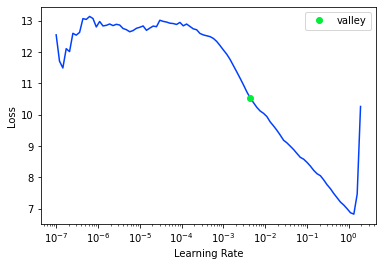

<Figure size 720x720 with 0 Axes>

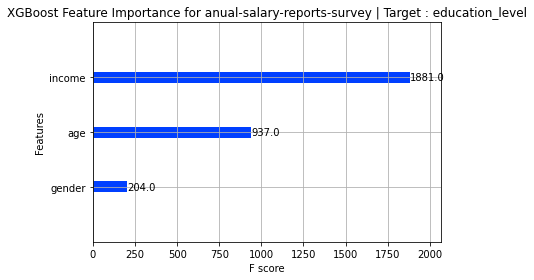

Target Variable: age
CATS=====================
['age', 'gender', 'education_level']
CONTS=====================
['income']
4
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['income']
Categorical variables that made the cut : ['age', 'gender', 'education_level']
Tabular Object size: 2000


  5%|▍         | 2/42 [00:00<00:02, 19.18it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.008661900554001845, 'Adjusted R-Squared': -0.01630327858850178, 'RMSE': 11.933351550485202, 'Time taken': 0.044760942459106445}
{'Model': 'BaggingRegressor', 'R-Squared': -0.2575688220822807, 'Adjusted R-Squared': -0.26709585861320706, 'RMSE': 13.324640708101663, 'Time taken': 0.05928945541381836}


 17%|█▋        | 7/42 [00:00<00:01, 31.50it/s]

{'Model': 'BayesianRidge', 'R-Squared': -0.0015451128549064386, 'Adjusted R-Squared': -0.00913257583108007, 'RMSE': 11.891178120121387, 'Time taken': 0.015803813934326172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.9263082273781762, 'Adjusted R-Squared': -0.9409014715249806, 'RMSE': 16.491209779758428, 'Time taken': 0.016518831253051758}
{'Model': 'DummyRegressor', 'R-Squared': -0.001543910018435346, 'Adjusted R-Squared': -0.009131363882211474, 'RMSE': 11.891170979580817, 'Time taken': 0.011412620544433594}
{'Model': 'ElasticNet', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.011256933212280273}
{'Model': 'ElasticNetCV', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.07329130172729492}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.9393764678529253, 'Adjusted R-Squared': -0.954068713821508, 'RMSE': 16.547054118482844, 'Time taken': 0.0157

 26%|██▌       | 11/42 [00:00<00:03, 10.01it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -266124.3696077017, 'Adjusted R-Squared': -268140.4708926086, 'RMSE': 6129.608900967524, 'Time taken': 0.4332611560821533}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.025562570751831215, 'Adjusted R-Squared': -0.033331984166617756, 'RMSE': 12.032911086882542, 'Time taken': 0.1977071762084961}


 38%|███▊      | 16/42 [00:01<00:03,  7.71it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.11069956432917816, 'Adjusted R-Squared': -0.11911395496803556, 'RMSE': 12.522410236197858, 'Time taken': 0.5227606296539307}
{'Model': 'HuberRegressor', 'R-Squared': -0.0022304078262875837, 'Adjusted R-Squared': -0.009823062431032259, 'RMSE': 11.895245620918079, 'Time taken': 0.02198481559753418}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.142400791602469, 'Adjusted R-Squared': -0.15105534305400292, 'RMSE': 12.69985826692566, 'Time taken': 0.016239643096923828}
{'Model': 'KernelRidge', 'R-Squared': -4.258385429494871, 'Adjusted R-Squared': -4.29822168274862, 'RMSE': 27.24682, 'Time taken': 0.14927959442138672}


 52%|█████▏    | 22/42 [00:02<00:01, 12.32it/s]

{'Model': 'Lars', 'R-Squared': -0.0024690996817533506, 'Adjusted R-Squared': -0.010063562558130235, 'RMSE': 11.896662, 'Time taken': 0.05011105537414551}
{'Model': 'LarsCV', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.047013044357299805}
{'Model': 'Lasso', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.026496410369873047}
{'Model': 'LassoCV', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.08359193801879883}
{'Model': 'LassoLars', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.013680696487426758}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0015439111800290561, 'Adjusted R-Squared': -0.009131365052605034, 'RMSE': 11.891171, 'Time taken': 0.02259993553161621}
{'Model': 'LassoLarsIC', 'R-Squared': -0.00154391118002

 62%|██████▏   | 26/42 [00:04<00:05,  3.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.008592560846204522, 'Adjusted R-Squared': -0.016233413579887834, 'RMSE': 11.932941, 'Time taken': 2.821671962738037}


 67%|██████▋   | 28/42 [00:05<00:03,  3.59it/s]

{'Model': 'NuSVR', 'R-Squared': -0.012003044159018206, 'Adjusted R-Squared': -0.0196697338874956, 'RMSE': 11.953099534446386, 'Time taken': 0.21400880813598633}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0028132801609628277, 'Adjusted R-Squared': -0.010410350465212437, 'RMSE': 11.898704107983905, 'Time taken': 0.012765169143676758}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0028132801609628277, 'Adjusted R-Squared': -0.010410350465212437, 'RMSE': 11.898704107983905, 'Time taken': 0.02072882652282715}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5030894291837471, 'Adjusted R-Squared': -0.5144764703139271, 'RMSE': 14.567399706666391, 'Time taken': 0.011595726013183594}
{'Model': 'PoissonRegressor', 'R-Squared': -0.002401736878995031, 'Adjusted R-Squared': -0.009995689431108623, 'RMSE': 11.896262310322804, 'Time taken': 0.012791156768798828}


 79%|███████▊  | 33/42 [00:58<00:41,  4.61s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0021817593147237524, 'Adjusted R-Squared': -0.009774045370138262, 'RMSE': 11.894956918334229, 'Time taken': 53.13260746002197}
{'Model': 'RANSACRegressor', 'R-Squared': -0.07003205171161975, 'Adjusted R-Squared': -0.0781383551336774, 'RMSE': 12.291023, 'Time taken': 0.12192177772521973}


 83%|████████▎ | 35/42 [00:58<00:24,  3.49s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.22071999630264427, 'Adjusted R-Squared': -0.2299678750625127, 'RMSE': 13.127972425321438, 'Time taken': 0.42630457878112793}
{'Model': 'Ridge', 'R-Squared': -0.002468168369770485, 'Adjusted R-Squared': -0.010062624190753544, 'RMSE': 11.896657, 'Time taken': 0.01419210433959961}
{'Model': 'RidgeCV', 'R-Squared': -0.002459818229357813, 'Adjusted R-Squared': -0.010054210791701435, 'RMSE': 11.896606953066986, 'Time taken': 0.013521909713745117}
{'Model': 'SGDRegressor', 'R-Squared': -0.0025914774003701346, 'Adjusted R-Squared': -0.010186867380675979, 'RMSE': 11.897388154446006, 'Time taken': 0.012725353240966797}


 90%|█████████ | 38/42 [00:59<00:09,  2.29s/it]

{'Model': 'SVR', 'R-Squared': -0.01036143795467992, 'Adjusted R-Squared': -0.018015691272518453, 'RMSE': 11.94340082532114, 'Time taken': 0.18964505195617676}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.0024690986685140803, 'Adjusted R-Squared': -0.010063561537214882, 'RMSE': 11.896662, 'Time taken': 0.0175020694732666}
{'Model': 'TweedieRegressor', 'R-Squared': -0.0018683387076305902, 'Adjusted R-Squared': -0.009458250364506648, 'RMSE': 11.893096768660055, 'Time taken': 0.017950057983398438}


100%|██████████| 42/42 [00:59<00:00,  1.43s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.1702164290119299, 'Adjusted R-Squared': -0.179081704989293, 'RMSE': 12.853539, 'Time taken': 0.5484027862548828}
{'Model': 'LGBMRegressor', 'R-Squared': -0.09503543993014163, 'Adjusted R-Squared': -0.1033311629599154, 'RMSE': 12.43379532179661, 'Time taken': 0.14455366134643555}
Project: anual-salary-reports-survey
anual-salary-reports-survey
Target: age
age
Target Standard Deviation: 11.80000620696341
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
DummyRegressor                              -0.01      -0.00   11.89   
LassoLarsCV                                 -0.01      -0.00   11.89   
LarsCV                                      -0.01      -0.00   11.89   
ElasticNet                                  -0.01      -0.00   11.89   
ElasticNetCV                                -0.01      -0.00   11.89   
LassoLarsIC                                 -0.0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,341.533966,381.679260,19.536613,00:01
1,216.078674,306.000366,17.492867,00:01
2,163.279648,206.260101,14.361758,00:01
3,125.256927,149.131973,12.211961,00:01
4,99.038414,153.704636,12.397767,00:01


Better model found at epoch 0 with _rmse value: 19.53661346435547.
Better model found at epoch 1 with _rmse value: 17.49286651611328.
Better model found at epoch 2 with _rmse value: 14.3617582321167.
Better model found at epoch 3 with _rmse value: 12.211960792541504.
No improvement since epoch 3: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      39      32.47
1      27      24.34
2       8      32.89
3      23      29.47
4      18      27.08
XGBoost RMSE:  12.853539


<Figure size 432x288 with 0 Axes>

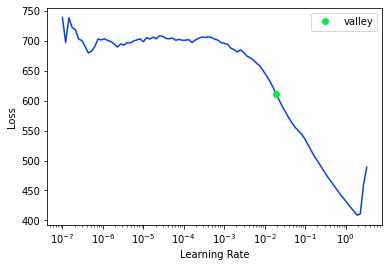

<Figure size 720x720 with 0 Axes>

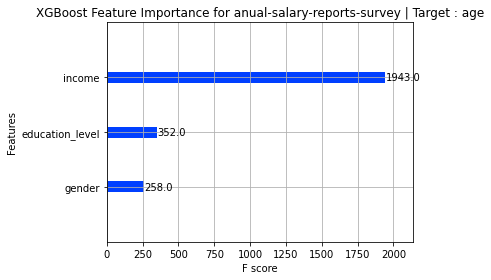

<Figure size 432x288 with 0 Axes>

In [19]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

           feature  importance
0           gender      258.00
1  education_level      352.00
2           income     1943.00
0              age      937.00
1           gender      204.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

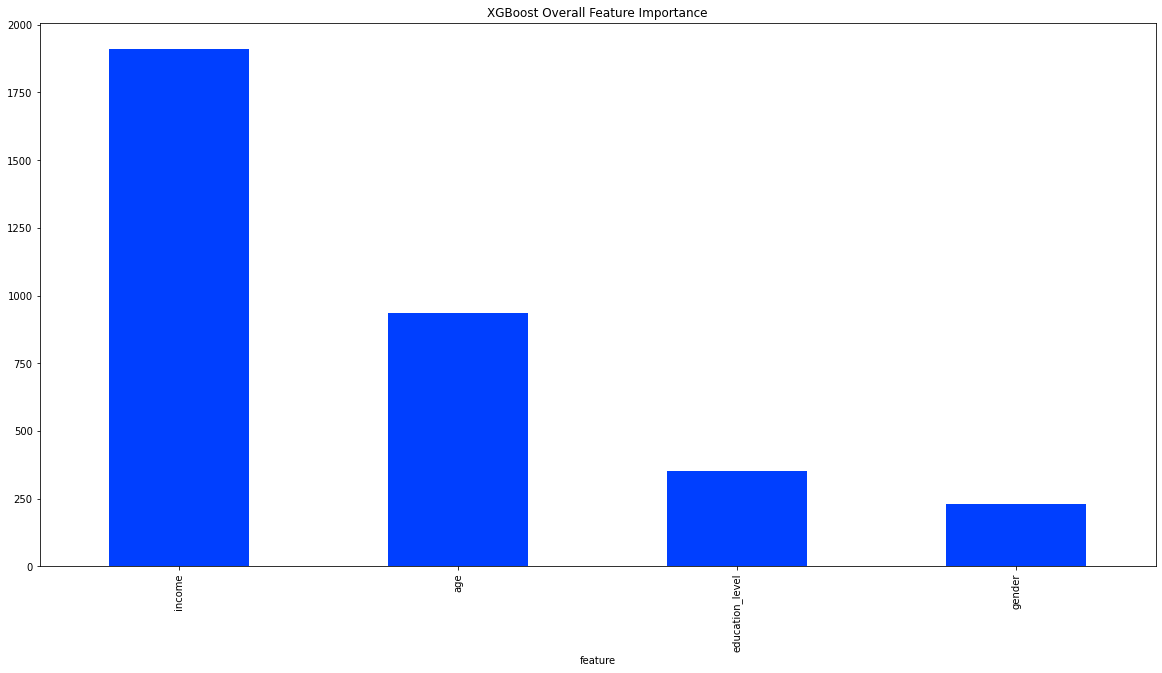

In [20]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [21]:
df.isna().sum()

income             0
age                0
gender             0
education_level    0
dtype: int64

# **To Be Continued...**